# Explore renthop data


The target variable, interest_level, is defined by the number of inquiries a listing has in the duration that the listing was live on the site. 



In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.basemap import Basemap

In [3]:
train = pd.read_json('data/train.json')
train = train.set_index('listing_id')
train['created'] = pd.to_datetime(train['created'])

In [4]:
train.shape

(49352, 14)

In [5]:
train.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'longitude', 'manager_id', 'photos', 'price', 'street_address'],
      dtype='object')

In [6]:
# what is submitted?

submission = pd.read_csv('data/sample_submission.csv.zip', compression='zip')

In [7]:
# for each listing_id will be generating probabilities for each of high, medium , low
submission.head(3)

,listing_id,high,medium,low
0,7142618,0.077788,0.227529,0.694683
1,7210040,0.077788,0.227529,0.694683
2,7174566,0.077788,0.227529,0.694683


In [8]:
# sample submission is just the proportions of interest as in the training set
train_proportions = train.interest_level.value_counts(normalize=True)
train_proportions

low       0.694683
medium    0.227529
high      0.077788
Name: interest_level, dtype: float64

# evaluation

multi-class logarithmic loss. 



In [9]:
from sklearn import metrics

In [10]:
predictions = pd.DataFrame({'listing_id': train.index.values, 
              'high': train_proportions['high'],
              'medium': train_proportions['medium'],
              'low': train_proportions['low']})
predictions.head(1)

,high,listing_id,low,medium
0,0.077788,7211212,0.694683,0.227529


In [11]:
predictions = predictions \
                .set_index('listing_id') \
                .assign(actual = train.interest_level)

In [12]:
metrics.log_loss(predictions.actual, predictions.drop('actual', 1).values)

0.78857691143225461

# data exploration

## some distributions

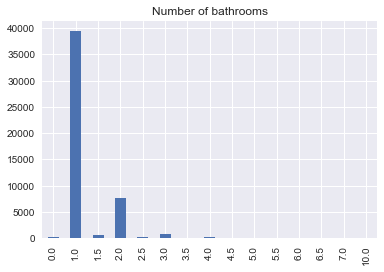

In [13]:
train.bathrooms.value_counts().sort_index().plot.bar()
plt.title('Number of bathrooms')

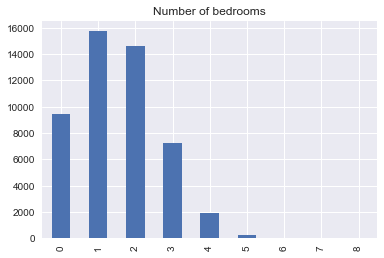

In [14]:
train.bedrooms.value_counts().sort_index().plot.bar()
plt.title('Number of bedrooms')

In [15]:
## is this missing data or....

train.loc[train.bedrooms == 0].shape

(9475, 14)

In [16]:
train.loc[train.bedrooms == 0].interest_level.value_counts()

low       6518
medium    2110
high       847
Name: interest_level, dtype: int64

In [17]:
train.manager_id.nunique()

3481

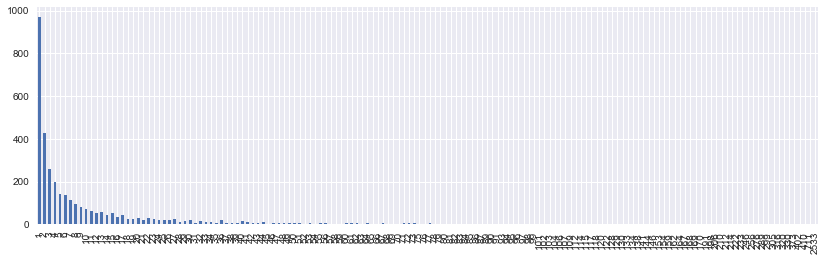

In [18]:
train.manager_id.value_counts().value_counts().sort_index().plot.bar(figsize=(14,4))

In [19]:
## maybe there are some managers that are better at getting higher interest level

listings_per_manager_by_interest_level = (train
.groupby(['manager_id', 'interest_level'])
.size()
.reset_index()
.pipe(pd.pivot_table, index='manager_id', columns='interest_level', values=0)
.fillna(0)
.astype(int)[['low', 'medium', 'high']]
)

In [20]:
## how to visualise this?? clustering??

listings_per_manager_by_interest_level.shape

(3481, 3)

In [21]:
interest_proportions_per_manager = listings_per_manager_by_interest_level.divide(listings_per_manager_by_interest_level.sum(1), axis=0)

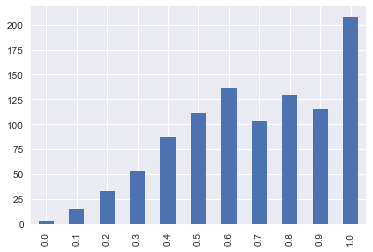

In [22]:
## there seems to be a bunch that only have low interest listings

interest_proportions_per_manager.loc[listings_per_manager_by_interest_level.sum(1) > 10].low.round(1).value_counts().sort_index().plot.bar()

In [23]:
## create feature of being low interest manager_id

In [24]:
low_interest_manager_ids = interest_proportions_per_manager.loc[((listings_per_manager_by_interest_level.sum(1) > 10)
                                     & (interest_proportions_per_manager.low > 0.95))].index.values
low_interest_manager_ids.shape

(207,)

In [25]:
train[train.manager_id.isin(low_interest_manager_ids)].interest_level.value_counts(normalize=True)

low       0.989061
medium    0.008812
high      0.002127
Name: interest_level, dtype: float64

In [26]:
## function to create feature that indicates low interest manager id

train.loc[:,'low_interest_manager_id'] = 0
train.loc[train.manager_id.isin(low_interest_manager_ids), 'low_interest_manager_id'] = 1
train.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,longitude,manager_id,photos,price,street_address,low_interest_manager_id
listing_id,,,,,,,,,,,,,,,
7211212,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,0


In [27]:
train.low_interest_manager_id.sum()

6582

/Users/danielg/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


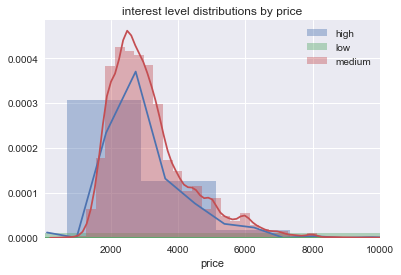

In [28]:

train.groupby('interest_level').apply(lambda x: sns.distplot(x.price, label=x.name))
plt.xlim(50, 10000)
plt.legend()
plt.title('interest level distributions by price')

In [29]:
n_interest_levels = train.interest_level.value_counts()

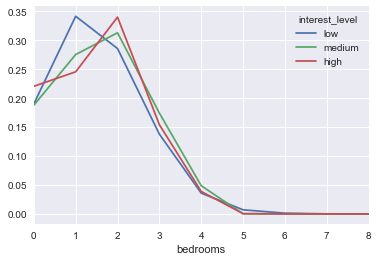

In [30]:
(train
.groupby(['interest_level', 'bedrooms'])
.size()
.reset_index()
.pipe(pd.pivot_table, columns='interest_level', index='bedrooms', values=0)
.fillna(0).astype(int)
[['low', 'medium', 'high']]
.divide(n_interest_levels)
).plot.line()

In [31]:
train['description_length'] = train.description.apply(lambda x: len(x))

/Users/danielg/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


interest_level
high      Axes(0.125,0.125;0.775x0.755)
low       Axes(0.125,0.125;0.775x0.755)
medium    Axes(0.125,0.125;0.775x0.755)
dtype: object

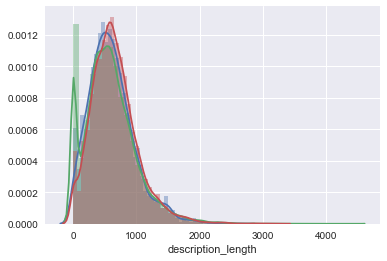

In [32]:
(train
.groupby(['interest_level'])
.apply(lambda x: sns.distplot(x.description_length, label=x.name))
)

In [266]:
train['description_n_words'] = train.description.apply(lambda x: len([x for x in x.split(' ') if x != '']))

## Location

In [33]:
high_latitudes = train.loc[((train.latitude != 0) & (train.longitude != 0) & (train.interest_level == 'high'))]
high_level_latitude = high_latitudes.latitude.tolist()
high_level_longitude = high_latitudes.longitude.tolist()


In [34]:
med_latitudes = train.loc[((train.latitude != 0) & (train.longitude != 0) & (train.interest_level == 'medium'))]
med_level_latitude = med_latitudes.latitude.tolist()
med_level_longitude = med_latitudes.longitude.tolist()


In [35]:
low_latitudes = train.loc[((train.latitude != 0) & (train.longitude != 0) & (train.interest_level == 'low'))]
low_level_latitude = low_latitudes.latitude.tolist()
low_level_longitude = low_latitudes.longitude.tolist()


/Users/danielg/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/danielg/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/danielg/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/danielg/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


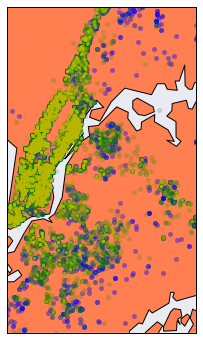

In [36]:
lower = 0.5
upper = 99.5

plt.figure(figsize=(12,6))

my_map = Basemap(projection='merc', 
                 lat_0=np.mean(train.latitude), 
                 lon_0=np.mean(train.longitude),
                 resolution = 'h', 
                 area_thresh = 0.1,
                 llcrnrlon=np.percentile(train.longitude, lower), 
                 llcrnrlat=np.percentile(train.latitude, lower),
                 urcrnrlon=np.percentile(train.longitude, upper), 
                 urcrnrlat=np.percentile(train.latitude, upper))
 
my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents(color='coral')
my_map.drawmapboundary()
 
x,y = my_map(high_level_longitude, high_level_latitude)
my_map.plot(x, y, 'bo', markersize=5, alpha=0.4)

x,y = my_map(med_level_longitude, med_level_latitude)
my_map.plot(x, y, 'go', markersize=5, alpha=0.2)

x,y = my_map(low_level_longitude, low_level_latitude)
my_map.plot(x, y, 'yo', markersize=3, alpha=0.1)

plt.show()

## Created

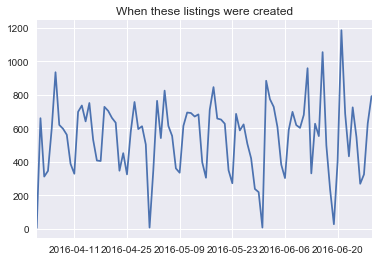

In [37]:
train.created.dt.date.value_counts().sort_index().plot.line()
plt.title('When these listings were created')
plt.show()

/Users/danielg/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


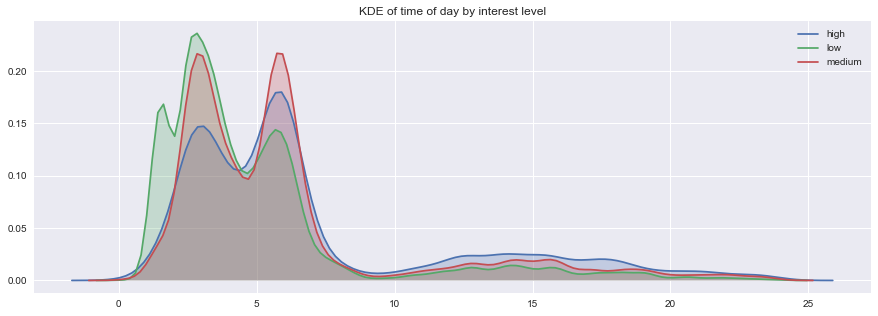

In [38]:
plt.figure(figsize=(15,5))
(train
.groupby('interest_level')
.apply(lambda df: sns.kdeplot((df.created.dt.hour 
                               + (df.created.dt.minute / 60)
                               + (df.created.dt.second / 360))
                              , shade=True, label=df.name))
)
plt.title('KDE of time of day by interest level')
plt.legend()
plt.show()

In [189]:
train['day_of_week'] = train['created'].dt.dayofweek
train['hour_of_day'] = train['created'].dt.hour

In [357]:
train['month'] = train['created'].dt.month

In [355]:
train['created'].dt.year.value_counts()

2016    49352
Name: created, dtype: int64

In [356]:
train['created'].dt.month.value_counts()

6    17144
4    16411
5    15797
Name: created, dtype: int64

## Building Id

In [39]:
train.shape

(49352, 16)

In [40]:
train.building_id.nunique()

7585

In [41]:
## this seems to be higher than the typical distribution?
train[train.building_id == '0'].interest_level.value_counts(normalize=True)

low       0.915762
medium    0.060705
high      0.023534
Name: interest_level, dtype: float64

In [42]:
by_building_id = (train
.loc[train.building_id != '0']
.groupby(['building_id', 'interest_level'])
.size()
.reset_index()
.pipe(pd.pivot_table, columns='interest_level', index='building_id', values=0)
.fillna(0).astype(int)
[['low', 'medium', 'high']]
)

In [43]:
by_building_proportions = by_building_id.divide(by_building_id.sum(1), axis=0)

In [44]:
low_interest_buildings = (by_building_proportions.
                            loc[((by_building_id.sum(1) > 10) & 
                                 (by_building_proportions.low > 0.95))])
low_interest_buildings.head(1)

interest_level,low,medium,high
building_id,,,
009f494b0636f32b96b41926ec7c4bf2,1.0,0.0,0.0


In [45]:
train.loc[train.building_id.isin(low_interest_buildings.index.values)].interest_level.value_counts()

low       1372
medium      23
high         1
Name: interest_level, dtype: int64

In [46]:
train.loc[:,'low_interest_building_id'] = 0
train.loc[train.building_id.isin(low_interest_buildings.index.values), 'low_interest_building_id'] = 1
train.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,longitude,manager_id,photos,price,street_address,low_interest_manager_id,description_length,low_interest_building_id
listing_id,,,,,,,,,,,,,,,,,
7211212,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,0,588,0


In [47]:
train.loc[:,'no_building_id'] = 0
train.loc[train.building_id == '0', 'no_building_id'] = 1
train.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,longitude,manager_id,photos,price,street_address,low_interest_manager_id,description_length,low_interest_building_id,no_building_id
listing_id,,,,,,,,,,,,,,,,,,
7211212,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,0,588,0,0


In [48]:
train.low_interest_building_id.sum()

1396

In [49]:
train.groupby(['low_interest_manager_id', 'low_interest_building_id', 'no_building_id']).size()

low_interest_manager_id  low_interest_building_id  no_building_id
0                        0                         0                 36646
                                                   1                  5002
                         1                         0                  1122
1                        0                         0                  3024
                                                   1                  3284
                         1                         0                   274
dtype: int64

## features

In [74]:
train['n_features'] = train.features.apply(lambda x: len(x))

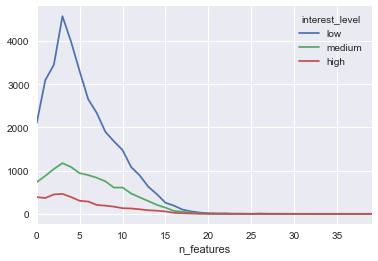

In [86]:
(train
.groupby(['n_features', 'interest_level'])
.size().reset_index()
.pipe(pd.pivot_table, columns='interest_level', index='n_features', values=0)
.fillna(0).astype(int)
 [['low', 'medium', 'high']]
.plot.line()
)

## are there high interest features
+ how many types of features are there?

In [522]:
features = []
for i in train['features']:
    features.extend(i)
features = set(features)

In [523]:
# total number of features
len(features)

1556

In [537]:
train.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'longitude', 'manager_id', 'photos', 'price', 'street_address',
       'low_interest_manager_id', 'description_length',
       'low_interest_building_id', 'no_building_id', 'n_features', 'n_photos',
       'has_zero_photos', 'low_interest_display_address', 'day_of_week',
       'hour_of_day', 'log_price', 'description_n_words',
       'log_description_length', 'month', 'latitude_norm', 'longitude_norm'],
      dtype='object')

In [554]:
feature_counts = list()
for name, i in train.loc[train.n_features > 0].iterrows():
    id_d = {'listing_id': name}
    vals_d = pd.Series(i.features).value_counts().to_dict()
    row_dict = {**id_d, **vals_d}
    feature_counts.append(row_dict)

In [555]:
feature_counts = pd.DataFrame(feature_counts)

should look for the most desirable features

In [ ]:
train.features

## photos

In [100]:
train['n_photos'] = train.photos.apply(lambda x: len(x))

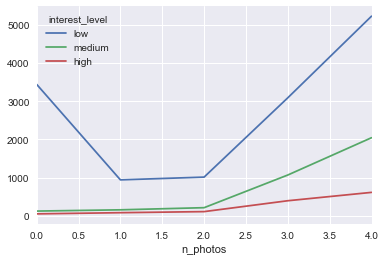

In [104]:
(train
.loc[train.n_photos < 5]
.groupby(['n_photos', 'interest_level'])
.size().reset_index()
.pipe(pd.pivot_table, columns='interest_level', index='n_photos', values=0)
.fillna(0).astype(int)
 [['low', 'medium', 'high']]
.plot.line()
)

looks like a the zero photos 

In [112]:
train.loc[:,'has_zero_photos'] = 0
train.loc[train.n_photos == 0, 'has_zero_photos'] = 1
train.groupby(['interest_level', 'has_zero_photos']).size()

interest_level  has_zero_photos
high            0                   3789
                1                     50
low             0                  30842
                1                   3442
medium          0                  11106
                1                    123
dtype: int64

## display address

In [148]:
display_x_tab = (train
 .groupby(['display_address', 'interest_level'])
 .size().reset_index()
 .pipe(pd.pivot_table, columns='interest_level', index='display_address', values=0)
 .fillna(0).astype(int)
 [['low', 'medium', 'high']]
)

In [151]:
display_x_tab_proportions = display_x_tab.divide(display_x_tab.sum(1), 0)

In [162]:
low_interest_addresses = display_x_tab_proportions.loc[((display_x_tab.sum(1) > 20) & (display_x_tab_proportions.low > 0.9))]
low_interest_addresses.index.values

array(['5th Ave.', '888 Eighth Avenue', 'Broad Street', 'Center Boulevard',
       'Central Park West', 'Charles Street', 'Cliff Street',
       'Cooper Square', 'E 14 Street', 'E 28th St', 'E 49th St.',
       'E 63rd St.', 'E 72 Street', 'E 72nd St.', 'E 77 Street',
       'E 84th St.', 'E 86 Street', 'E 87th St.', 'E 89th St.',
       'East 100th Street', 'East 117th Street', 'East 1st Street',
       'East 20th Street', 'East 49th Street', 'East 60th Street',
       'East 65th Street', 'East 66th Street', 'East 72nd Street',
       'East 77th Street', 'East 92nd Street', 'East 96th Street',
       'Greenwich Avenue', 'Horatio Street', 'Jones Street',
       'Lawrence Street', 'Manhattan Avenue', 'North 10th Street',
       'Peter Cooper Road', 'Riverside Blvd', 'Riverside Boulevard',
       'Saint Nicholas Avenue', 'Spruce Street', 'St Marks Place',
       'Stuyvesant Oval', 'Union Square South', 'W 55 Street',
       'W 57 Street', 'W 58 Street', 'W 62 St.', 'W 63rd St.',
       '

In [166]:
train.loc[train.display_address.isin(low_interest_addresses.index.values)].groupby(['interest_level']).size()

interest_level
high        21
low       2777
medium     179
dtype: int64

In [168]:
train.loc[:, 'low_interest_display_address'] = 0
train.loc[train.display_address.isin(low_interest_addresses.index.values), 'low_interest_display_address'] = 1

In [182]:
## don't seem to be many that are high interest?

display_x_tab_proportions.loc[((display_x_tab.sum(1) > 5) & (display_x_tab_proportions.high > 0.9))]

interest_level,low,medium,high
display_address,,,
Carlton St,0.0,0.0,1.0


In [184]:
train.loc[train.display_address == 'Carlton St'].interest_level.value_counts()

high    6
Name: interest_level, dtype: int64

## transformations?

In [324]:
from scipy.special import logit

In [226]:
train['log_price'] = np.log(train.price)

In [337]:
train['log_description_length'] = np.log(train.description_length + 0.01)
train['log_description_length'] = train['log_description_length'].fillna(0)

# some basic predictions

In [381]:
from sklearn import model_selection, linear_model, metrics, preprocessing

setup test and train

In [468]:
features = ['bathrooms', 
            'bedrooms', 
            'log_description_length', 
            'latitude', 
            'longitude', 
            'low_interest_manager_id',
           'low_interest_building_id', 
            'no_building_id',
           'n_features', 
            'n_photos', 
            'has_zero_photos',
           'low_interest_display_address',
           'hour_of_day', 
            'log_price']
X = train[features]
y = train['interest_level']

In [484]:
X.describe()

,bathrooms,bedrooms,log_description_length,latitude,longitude,low_interest_manager_id,low_interest_building_id,no_building_id,n_features,n_photos,has_zero_photos,low_interest_display_address,hour_of_day,log_price
count,49352.00000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000
mean,1.21218,1.541640,5.786637,40.741545,-73.955716,0.133368,0.028287,0.167896,5.428473,5.606946,0.073249,0.060322,4.764690,8.099032
std,0.50142,1.115018,2.114003,0.638535,1.177912,0.339976,0.165792,0.373778,3.923411,3.632283,0.260548,0.238084,4.190298,0.432838
min,0.00000,0.000000,-4.605170,0.000000,-118.271000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.761200
25%,1.00000,1.000000,5.828975,40.728300,-73.991700,0.000000,0.000000,0.000000,2.000000,4.000000,0.000000,0.000000,2.000000,7.824046
50%,1.00000,1.000000,6.335072,40.751800,-73.977900,0.000000,0.000000,0.000000,5.000000,5.000000,0.000000,0.000000,3.000000,8.055158
75%,1.00000,2.000000,6.695811,40.774300,-73.954800,0.000000,0.000000,0.000000,8.000000,7.000000,0.000000,0.000000,5.000000,8.318742
max,10.00000,8.000000,8.404251,44.883500,0.000000,1.000000,1.000000,1.000000,39.000000,68.000000,1.000000,1.000000,23.000000,15.317363


In [469]:
sk.__path__

['/Users/danielg/anaconda3/lib/python3.6/site-packages/sklearn']

In [470]:
sss = model_selection.StratifiedShuffleSplit(n_splits = 2, test_size=0.2, random_state=0)
sss.get_n_splits(X=X, y=y)

2

In [471]:
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TRAIN: [17984 36593  7219 ..., 17629 40833 20954] TEST: [37887 39631 10074 ..., 20903 26267 16106]
TRAIN: [47718 17388 47139 ..., 12099 27110 39561] TEST: [  501 33857  9196 ...,  7458 31635 42554]


In [472]:
X_train.head(1)

,bathrooms,bedrooms,log_description_length,latitude,longitude,low_interest_manager_id,low_interest_building_id,no_building_id,n_features,n_photos,has_zero_photos,low_interest_display_address,hour_of_day,log_price
listing_id,,,,,,,,,,,,,,
6891817,1.0,1,7.773599,40.678,-73.9909,0,0,0,7,9,0,0,2,8.080547


In [473]:
print(y_train.head(1))
print(y_train.shape)

listing_id
6891817    low
Name: interest_level, dtype: object
(39481,)


fit model

In [474]:
# default model to fit is one vs rest 
# tried multinomial and it was worse...
logreg = linear_model.LogisticRegression()

In [475]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

evaluate

In [476]:
y_pred = logreg.predict_proba(X_test)

In [477]:
y_pred_labels = logreg.predict(X_test)

In [478]:
metrics.log_loss(y_true=y_test, y_pred=y_pred)

0.64169907737666898

## try a different model

In [479]:
X_train.head(1)

,bathrooms,bedrooms,log_description_length,latitude,longitude,low_interest_manager_id,low_interest_building_id,no_building_id,n_features,n_photos,has_zero_photos,low_interest_display_address,hour_of_day,log_price
listing_id,,,,,,,,,,,,,,
6891817,1.0,1,7.773599,40.678,-73.9909,0,0,0,7,9,0,0,2,8.080547


In [480]:
from sklearn.ensemble import RandomForestClassifier

In [481]:
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)
y_val_pred = clf.predict_proba(X_test)

In [482]:
metrics.log_loss(y_true=y_test, y_pred=y_val_pred)

0.59356757941290195